<a href="https://colab.research.google.com/github/tarosmusicroom/VToonify-1/blob/main/VToonify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

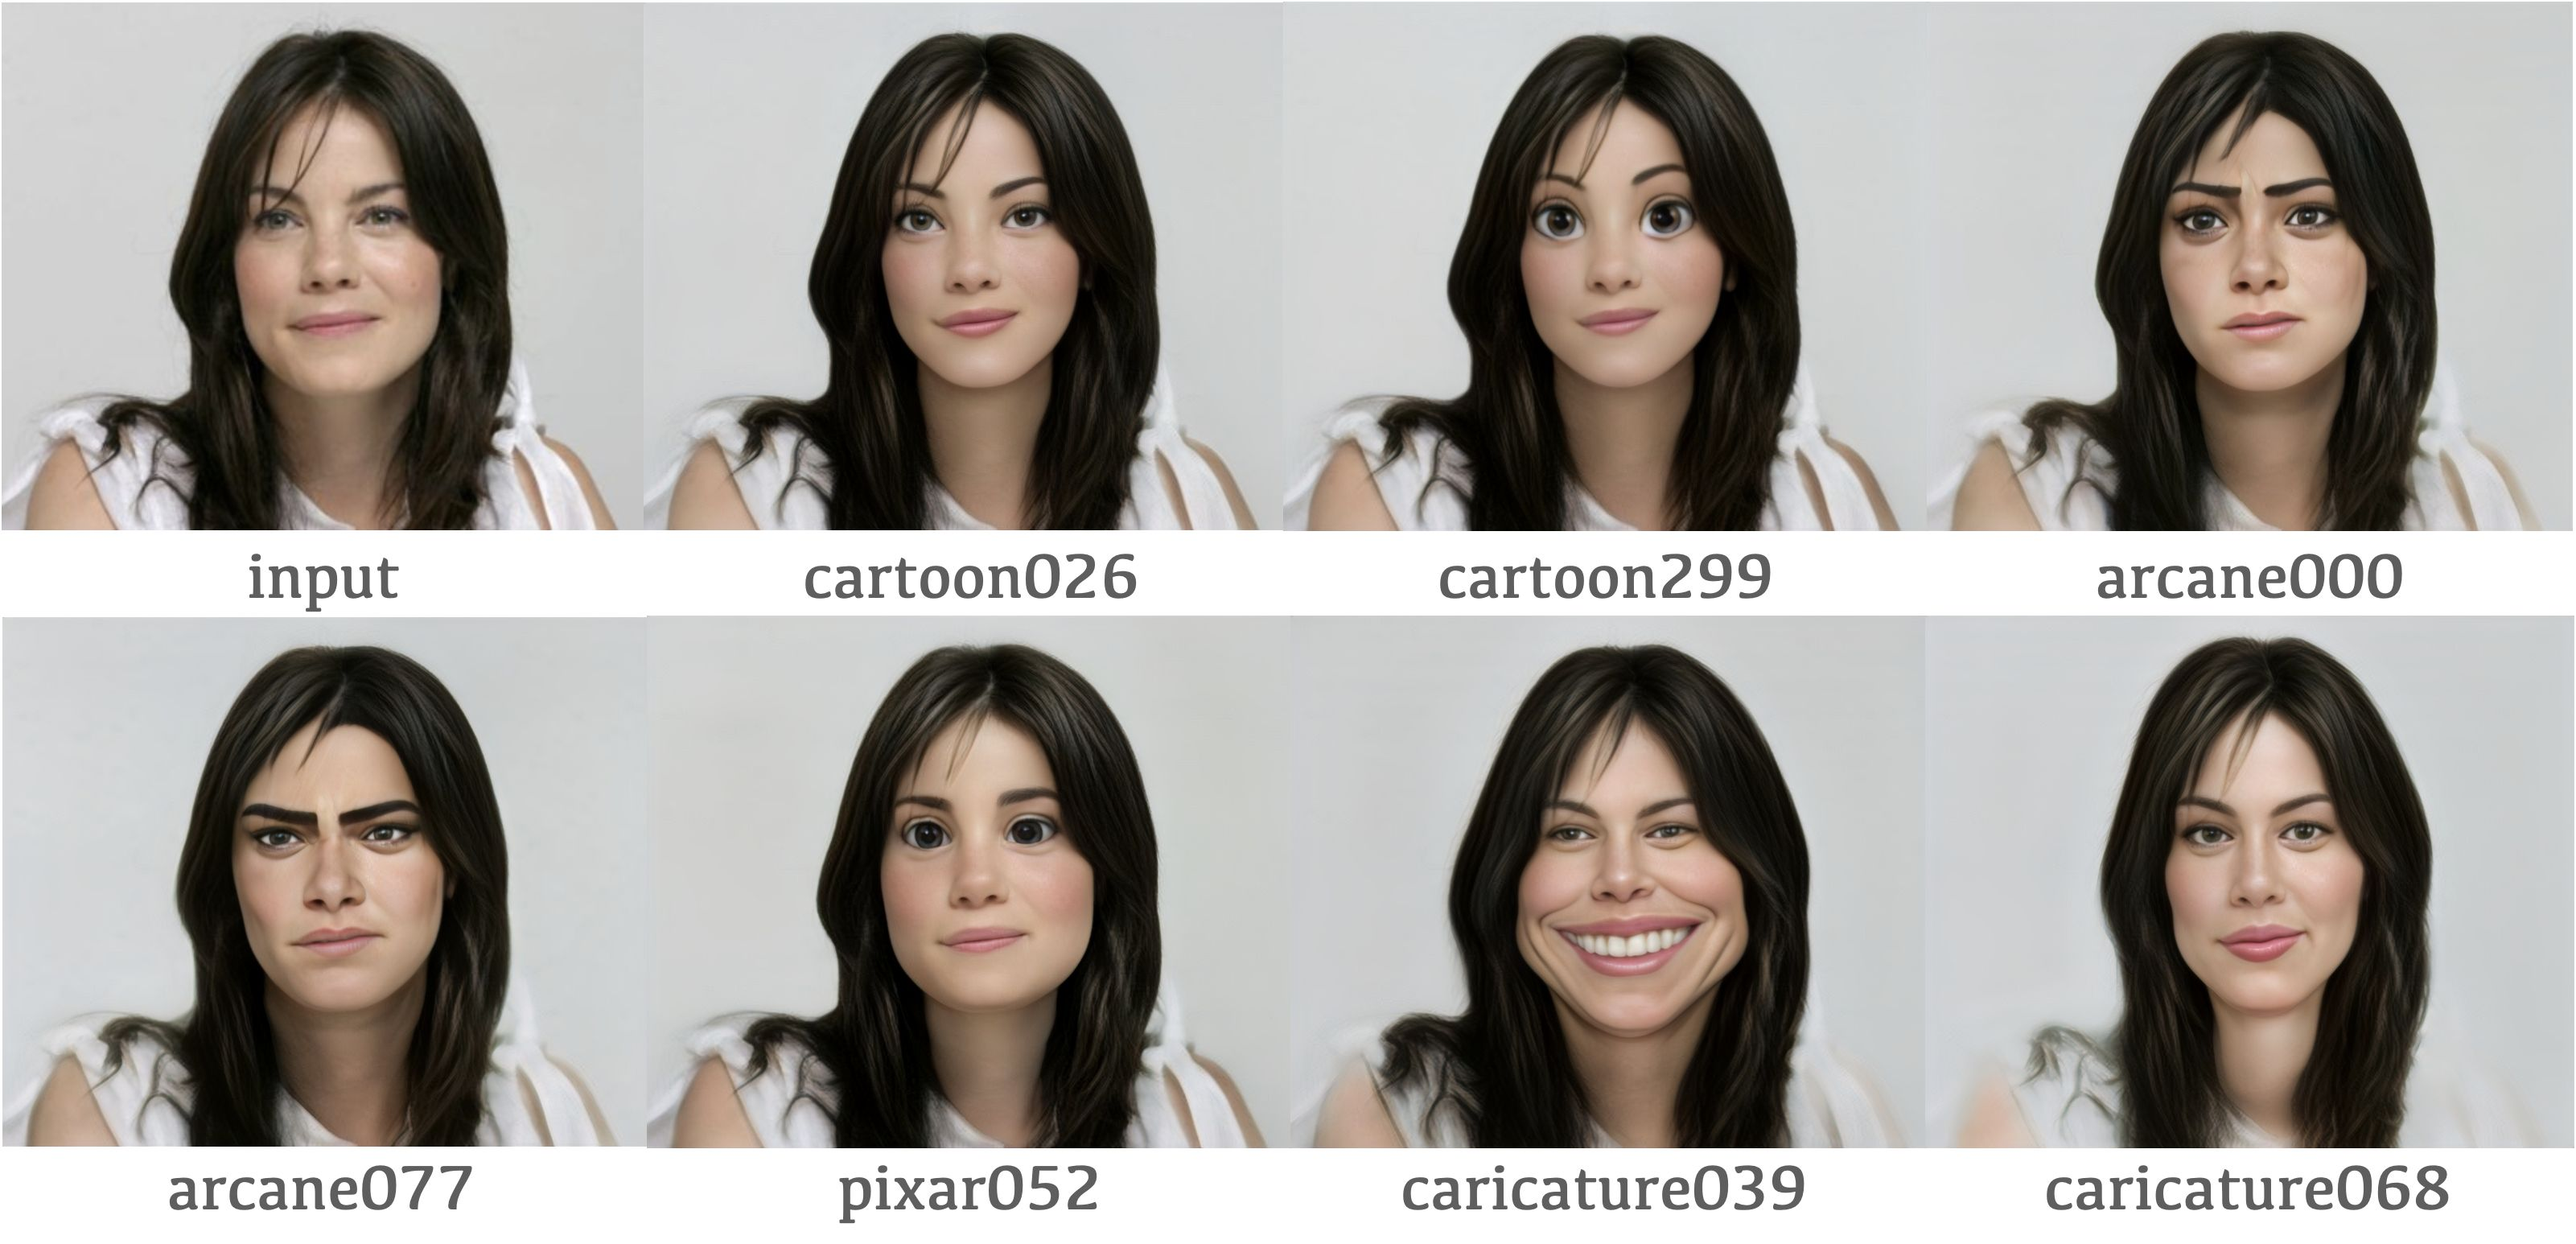

In [ ]:
#@title **セットアップ**

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
#os.chdir('../')
CODE_DIR = 'VToonify'
device = 'cuda'

!git clone https://github.com/tarosmusicroom/VToonify.git $CODE_DIR

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force 
!pip install wget

os.chdir(f'./{CODE_DIR}')
MODEL_DIR = os.path.join(os.path.dirname(os.getcwd()), CODE_DIR, 'checkpoint')
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), CODE_DIR, 'data')
OUT_DIR = os.path.join(os.path.dirname(os.getcwd()), CODE_DIR, 'output')

%load_ext autoreload
%autoreload 2
import sys
sys.path.append(".")
sys.path.append("..")
import argparse
import numpy as np
import cv2
import dlib
import torch
from torchvision import transforms
import torchvision
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from model.vtoonify import VToonify
from model.bisenet.model import BiSeNet
from model.encoder.align_all_parallel import align_face
from util import save_image, load_image, visualize, load_psp_standalone, get_video_crop_parameter, tensor2cv2

MODEL_PATHS = {
    "encoder": {"id": "1NgI4mPkboYvYw3MWcdUaQhkr0OWgs9ej", "name": "encoder.pt"},
    "faceparsing": {"id": "1jY0mTjVB8njDh6e0LP_2UxuRK3MnjoIR", "name": "faceparsing.pth"},
    "arcane_exstyle": {"id": "1TC67wRJkdmNRZTqYMUEFkrhWRKKZW40c", "name": "exstyle_code.npy"},
    "caricature_exstyle": {"id": "1xr9sx_WmRYJ4qHGTtdVQCSxSo4HP3-ip", "name": "exstyle_code.npy"},
    "cartoon_exstyle": {"id": "1BuCeLk3ASZcoHlbfT28qNru4r5f-hErr", "name": "exstyle_code.npy"},
    "pixar_exstyle": {"id": "1yTaKuSrL7I0i0RYEEK5XD6GI-y5iNUbj", "name": "exstyle_code.npy"},
    "arcane000": {"id": "1pF4fJ8acmawMsjjXo4HXRIOXeZR8jLVh", "name": "generator.pt"},
    "arcane077": {"id": "16rLTF2oC0ZeurnM6hjrfrc8BxtW8P8Qf", "name": "generator.pt"},
    "caricature039": {"id": "1C1E4WEoDWzl0nAxR9okKffFmlMOENbeF", "name": "generator.pt"},
    "caricature068": {"id": "1B1ko1x8fX2aJ4BYCL12AnknVAi3qQc8W", "name": "generator.pt"},
    "cartoon026": {"id": "1YJYODh_vEyUrL0q02okjcicpJhdYY8An", "name": "generator.pt"},
    "cartoon299": {"id": "101qMUMfcI2qDxEbfCBt5mOg2aSqdTaIt", "name": "generator.pt"},
    "pixar052": {"id": "16j_l1x0DD0PjwO8YdplAk69sh3-v95rr", "name": "generator.pt"},
    "cartoon": {"id": "11s0hwhZWTLacMAzZH4OU-o3Qkp54h30J", "name": "generator.pt"},
}


# download all checkpoint
import gdown
gdown.download('https://drive.google.com/uc?id=1l8aqqZJMLnmQtkz8HPzakblq5G_zMZAr', 'v1.zip', quiet=False)
! unzip -d checkpoint v1.zip
gdown.download('https://drive.google.com/uc?id=1hBcGhPmhZi01Jg6mvwD1yPyMVJgeiExX', 'v2.zip', quiet=False)
! unzip -d checkpoint v2.zip
gdown.download('https://drive.google.com/uc?id=11aTPKbdnqjaljyzhMCVLz07Q3-74Bgsj', 'v3.zip', quiet=False)
! unzip -d checkpoint v3.zip

%matplotlib inline
from function import *
! mkdir download

In [ ]:
#@title **モデルの選択**

style_type = "cartoon026" #@param ["cartoon026", "cartoon299", "arcane000", "arcane077", "pixar052", "caricature039", "caricature068", "comic000", "comic100"]



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5,0.5,0.5]),
    ])

vtoonify = VToonify(backbone = 'dualstylegan')
vtoonify.load_state_dict(torch.load(os.path.join(MODEL_DIR, style_type+'_generator.pt'), map_location=lambda storage, loc: storage)['g_ema'])
vtoonify.to(device)

parsingpredictor = BiSeNet(n_classes=19)
parsingpredictor.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'faceparsing.pth'), map_location=lambda storage, loc: storage))
parsingpredictor.to(device).eval()

modelname = './checkpoint/shape_predictor_68_face_landmarks.dat'
if not os.path.exists(modelname):
    import wget, bz2
    wget.download('http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2', modelname+'.bz2')
    zipfile = bz2.BZ2File(modelname+'.bz2')
    data = zipfile.read()
    open(modelname, 'wb').write(data) 
landmarkpredictor = dlib.shape_predictor(modelname)

pspencoder = load_psp_standalone(os.path.join(MODEL_DIR, 'encoder.pt'), device)    

exstyles = np.load(os.path.join(MODEL_DIR, style_type[:-3]+'_exstyle_code.npy'), allow_pickle='TRUE').item()
stylename = list(exstyles.keys())[int(style_type[-3:])]
exstyle = torch.tensor(exstyles[stylename]).to(device)
with torch.no_grad():  
    exstyle = vtoonify.zplus2wplus(exstyle)
    
print('Model successfully loaded!')

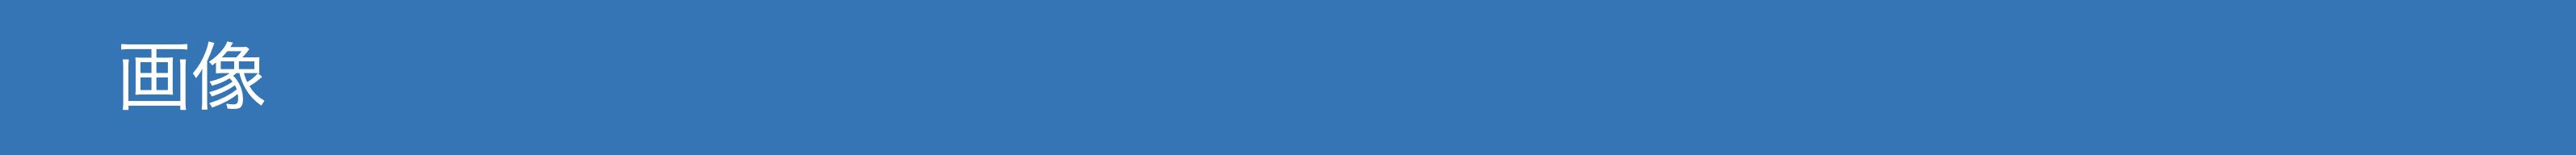

In [ ]:
#@title **画像のクロップ**
pic = '01.jpg' #@param {type:"string"}
image_path = './data/'+pic

frame = cv2.imread(image_path)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

scale = 1
kernel_1d = np.array([[0.125],[0.375],[0.375],[0.125]])
# We detect the face in the image, and resize the image so that the eye distance is 64 pixels.
# Centered on the eyes, we crop the image to almost 400x400 (based on args.padding).
paras = get_video_crop_parameter(frame, landmarkpredictor, padding=[200,200,200,200])
if paras is not None:
    h,w,top,bottom,left,right,scale = paras
    H, W = int(bottom-top), int(right-left)
    # for HR image, we apply gaussian blur to it to avoid over-sharp stylization results
    if scale <= 0.75:
        frame = cv2.sepFilter2D(frame, -1, kernel_1d, kernel_1d)
    if scale <= 0.375:
        frame = cv2.sepFilter2D(frame, -1, kernel_1d, kernel_1d)
    frame = cv2.resize(frame, (w, h))[top:bottom, left:right]
    x = transform(frame).unsqueeze(dim=0).to(device)
else:
    print('no face detected!')

# 画像出力
save_image(x[0].cpu(),'befor.jpg')
visualize(x[0].cpu(), 60)

In [ ]:
#@title **画像のアニメ化**

with torch.no_grad():
    I = align_face(frame, landmarkpredictor)
    I = transform(I).unsqueeze(dim=0).to(device)
    s_w = pspencoder(I)
    s_w = vtoonify.zplus2wplus(s_w)
    s_w[:,:7] = exstyle[:,:7]
    # parsing network works best on 512x512 images, so we predict parsing maps on upsmapled frames
    # followed by downsampling the parsing maps
    x_p = F.interpolate(parsingpredictor(2*(F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)))[0], 
                        scale_factor=0.5, recompute_scale_factor=False).detach()
    # we give parsing maps lower weight (1/16)
    inputs = torch.cat((x, x_p/16.), dim=1)
    # d_s has no effect when backbone is toonify
    y_tilde = vtoonify(inputs, s_w.repeat(inputs.size(0), 1, 1), d_s = 0.5)        
    y_tilde = torch.clamp(y_tilde, -1, 1)

# 画像出力
from google.colab.patches import cv2_imshow
import cv2
clear_output()
save_image(y_tilde[0].cpu(), 'after.jpg')
img_befor = cv2.imread('befor.jpg')
tmp = cv2.imread('after.jpg')
img_after = cv2.resize(tmp, dsize=(W, H))
img = cv2.hconcat([img_befor, img_after])
cv2.imwrite('img.jpg', img)
cv2_imshow(img)

In [ ]:
#@title **画像のダウンロード**
from google.colab import files
import os
import shutil
dst_file = 'download/'+os.path.splitext(pic)[0]+'_'+style_type+'.jpg'
shutil.copy('img.jpg', dst_file)
files.download(dst_file)

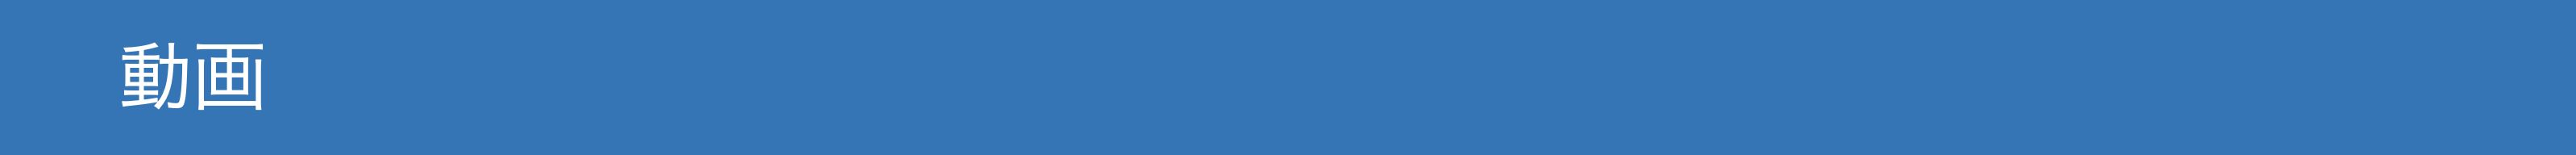

In [ ]:
#@title **動画のクロップ**

video = '03.mp4' #@param {type:"string"}
video_path = './data/'+video
video_cap = cv2.VideoCapture(video_path)
num = int(video_cap.get(7))

success, frame = video_cap.read()
if success == False:
    assert('load video frames error')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


scale = 1
kernel_1d = np.array([[0.125],[0.375],[0.375],[0.125]])
# We proprocess the video by detecting the face in the first frame, 
# and resizing the frame so that the eye distance is 64 pixels.
# Centered on the eyes, we crop the first frame to almost 400x400 (based on args.padding).
# All other frames use the same resizing and cropping parameters as the first frame.
paras = get_video_crop_parameter(frame, landmarkpredictor, padding=[200,200,200,200])
if paras is None:
    print('no face detected!')
else:
    h,w,top,bottom,left,right,scale = paras
    H, W = int(bottom-top), int(right-left)
# for HR video, we apply gaussian blur to the frames to avoid flickers caused by bilinear downsampling
# this can also prevent over-sharp stylization results. 
if scale <= 0.75:
    frame = cv2.sepFilter2D(frame, -1, kernel_1d, kernel_1d)
if scale <= 0.375:
    frame = cv2.sepFilter2D(frame, -1, kernel_1d, kernel_1d)
    
frame = cv2.resize(frame, (w, h))[top:bottom, left:right]


# 偶数補正
def even(x):
  if x % 2 != 0:
    x +=1
  return x
w = even(w)
h = even(h)

# ビデオクロップ
! ffmpeg -y -i $video_path -vf scale=$w:$h -loglevel error tmp.mp4
crop_size = 'crop='+str(W)+':'+str(H)+':'+str(left)+':'+str(top)
! ffmpeg -y -i tmp.mp4 -filter:v $crop_size -async 1 -loglevel error befor.mp4
display_mp4('befor.mp4') 

In [ ]:
#@title **動画のアニメ化**
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
videoWriter = cv2.VideoWriter(os.path.join(OUT_DIR, 'result.mp4'), fourcc, video_cap.get(5), (4*W, 4*H))
batch_size = 4

with torch.no_grad():
    batch_frames = []
    for i in tqdm(range(num)):
        if i == 0:        
            I = align_face(frame, landmarkpredictor)
            I = transform(I).unsqueeze(dim=0).to(device)
            s_w = pspencoder(I)
            s_w = vtoonify.zplus2wplus(s_w)
            s_w[:,:7] = exstyle[:,:7]
        else:
            success, frame = video_cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if scale <= 0.75:
                frame = cv2.sepFilter2D(frame, -1, kernel_1d, kernel_1d)
            if scale <= 0.375:
                frame = cv2.sepFilter2D(frame, -1, kernel_1d, kernel_1d)
            frame = cv2.resize(frame, (w, h))[top:bottom, left:right]

        batch_frames += [transform(frame).unsqueeze(dim=0).to(device)]

        if len(batch_frames) == batch_size or (i+1) == num:
            x = torch.cat(batch_frames, dim=0)
            batch_frames = []
            # parsing network works best on 512x512 images, so we predict parsing maps on upsmapled frames
            # followed by downsampling the parsing maps
            x_p = F.interpolate(parsingpredictor(2*(F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)))[0], 
                            scale_factor=0.5, recompute_scale_factor=False).detach()
            # we give parsing maps lower weight (1/16)
            inputs = torch.cat((x, x_p/16.), dim=1)
            # d_s has no effect when backbone is toonify
            y_tilde = vtoonify(inputs, s_w.repeat(inputs.size(0), 1, 1), d_s = 0.5)       
            y_tilde = torch.clamp(y_tilde, -1, 1)
            for k in range(y_tilde.size(0)):
                videoWriter.write(tensor2cv2(y_tilde[k].cpu()))
videoWriter.release()
video_cap.release()

# 動画出力
clear_output()
re_size = str(W)+'x'+str(H)
! ffmpeg -y -i ./output/result.mp4 -vcodec h264 -pix_fmt yuv420p -s $re_size -loglevel error after.mp4
! ffmpeg -y -i befor.mp4 -i after.mp4 -filter_complex "hstack" -loglevel error output.mp4
display_mp4('output.mp4')

In [ ]:
#@title **動画のダウンロード**
from google.colab import files
import os
import shutil
dst_file = 'download/'+os.path.splitext(video)[0]+'_'+style_type+'.mp4'
shutil.copy('output.mp4', dst_file)
files.download(dst_file)